Генерация данных.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
np.random.seed(0)

In [ ]:
f=lambda x: 2-np.exp(-(x-2)**2)-np.exp(-(x-6)**2/10)-1/(x**2+1)

(0.0, 2.0)

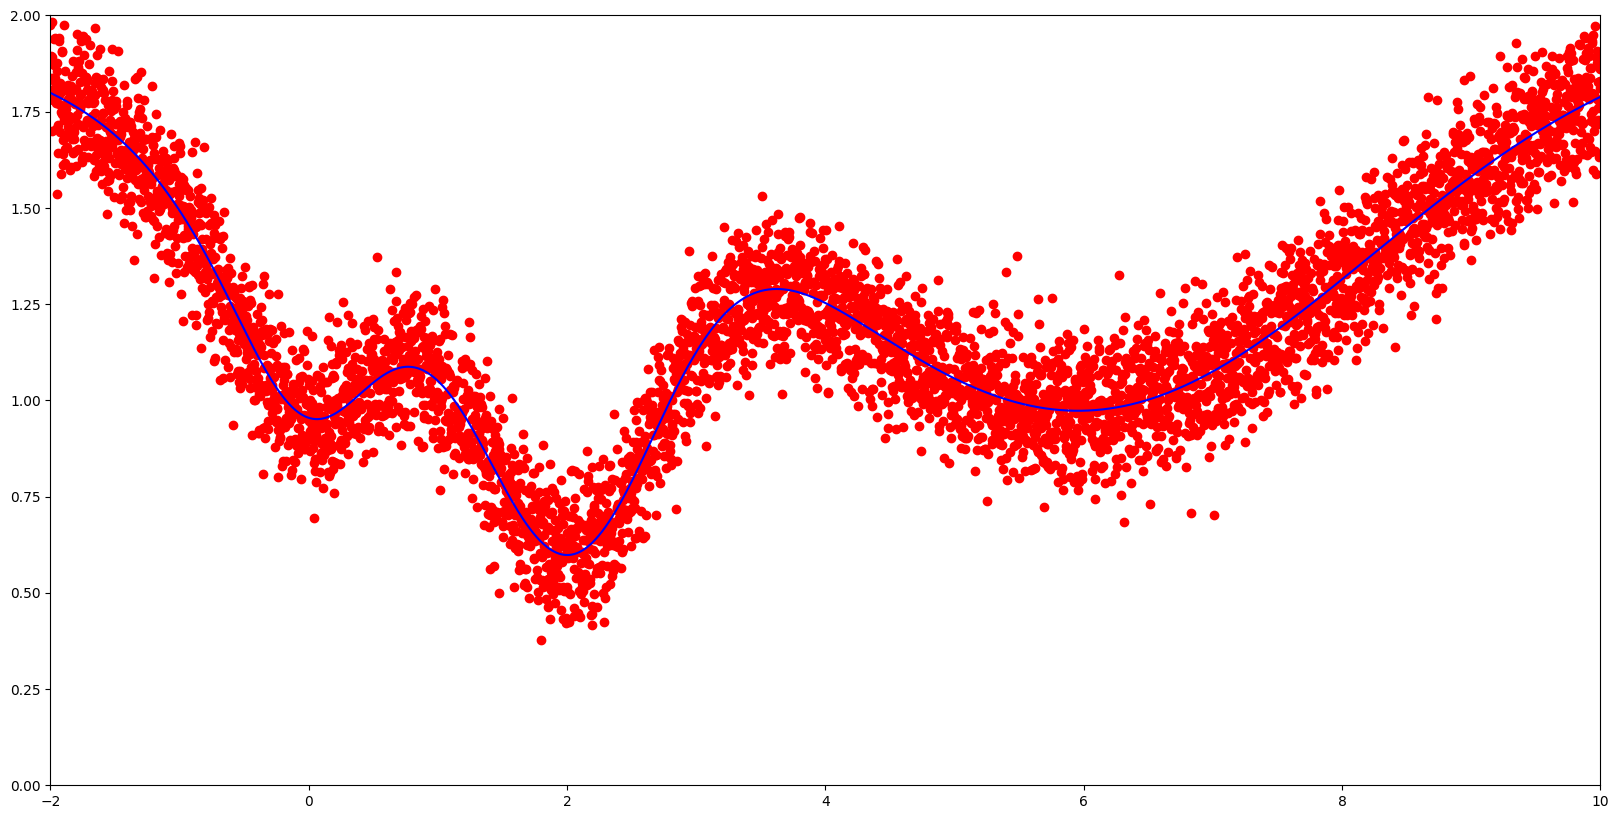

In [ ]:
N=5000
X=np.linspace(-2,10, num=N)
y_true=f(X)
err= np.random.normal(0, 0.1, N)
y=y_true+err
fig = plt.figure()
plt.plot(X, y_true, color='blue')
plt.scatter(X, y, color='red')
plt.xlim([-2.0,10.0])
plt.ylim([0.0,2.0])

Разделим множество на тренировочную, валидационную и тестовую выборки. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создаем датасеты и загрузчики пакетов.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cpu'

In [ ]:
class Simp_Reg_Dataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(data)
      self.targets = torch.Tensor(targets)
      self.transform = transform
      
  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index] 
      return x, y
  
  def __len__(self):
      return len(self.data)

In [ ]:
train_dataset=Simp_Reg_Dataset(X_train, y_train)
test_dataset=Simp_Reg_Dataset(X_test, y_test)

In [ ]:
train_dataset[0]

(tensor(8.1468), tensor(1.3452))

In [ ]:
batch_size=1 # размер пакета

In [ ]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True) # загрузчики данных
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

Так выглядит пакет данных.

(0.0, 2.0)

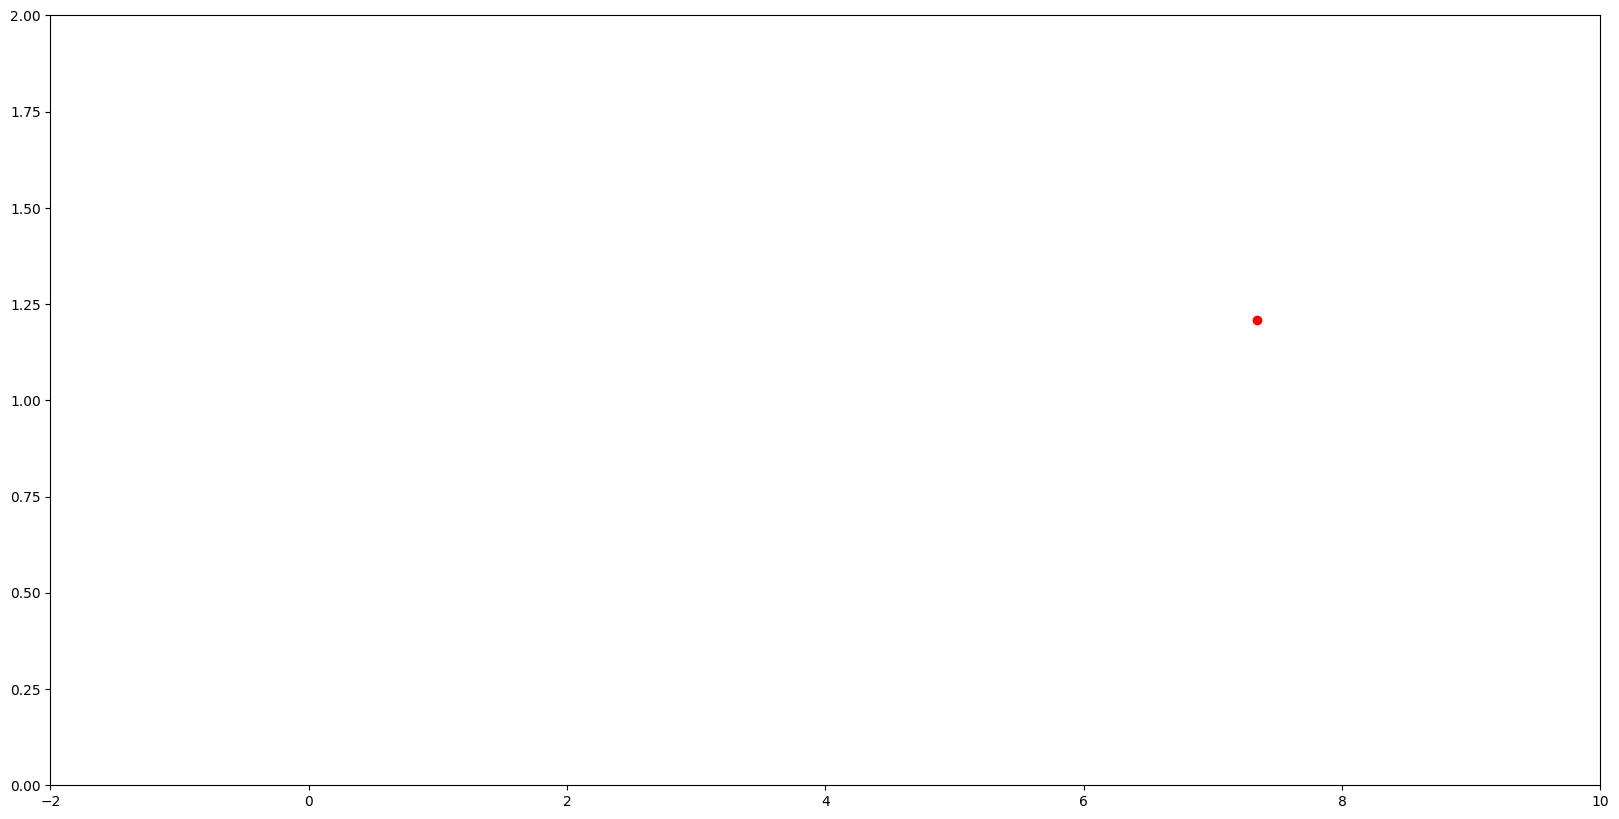

In [ ]:
batch=next(iter(train_loader))
input,target=batch
plt.scatter(input.to('cpu').detach().numpy(), target.to('cpu').detach().numpy(), color='red')
plt.xlim([-2.0,10.0])
plt.ylim([0.0,2.0])

Задаем архитектуру модели

In [ ]:
class Simp_Reg(nn.Module):
  def __init__(self):
    super(Simp_Reg, self).__init__()
    self.fc1 = nn.Linear(1, 10)
    self.fc2 = nn.Linear(10, 1)
    self.activation = nn.Tanh() # чтобы форма итоговой кривой была более гладкой :-)
  
  def forward(self, x):
    x=x.unsqueeze(-1) # костыль (проблема только 1d данных!)
    # 1-й слой
    x=self.fc1(x)
    x=self.activation(x)
    # финальный слой
    x=self.fc2(x)
    return x

In [ ]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

In [ ]:
model = Simp_Reg()
model.to(device)

Simp_Reg(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (activation): Tanh()
)

In [ ]:
summary(model, input_size=(5,1)) # детализация модели

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Simp_Reg                                 [5, 1, 1]                 --
├─Linear: 1-1                            [5, 1, 10]                20
├─Tanh: 1-2                              [5, 1, 10]                --
├─Linear: 1-3                            [5, 1, 1]                 11
Total params: 31
Trainable params: 31
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Прописываем цикл обучения и валидации.

In [ ]:
from tqdm import tqdm

In [ ]:
train_losses=[]
def train(model,epoch):
  print('\nEpoch : %d'%epoch)
  model.train() # веса модели можно обновлять
  running_loss=0
  for data in tqdm(train_loader):
      inputs, targets=data[0].to(device),data[1].to(device) # распаковываем пакеты
      optimizer.zero_grad() # обнуляем градиенты
      outputs=model(inputs) # считаем предсказания - прямой проход модели
      loss=criterion(outputs,targets) # ошибка пакета
      loss.backward() # обратное распространение ошибки
      optimizer.step() # итерация алгоритма оптимизации

      running_loss += loss.item()
  
  train_loss=running_loss/len(train_loader)
  train_losses.append(train_loss)
  print('Ошибка обучения в эпохе: %.4f'%(train_loss))

In [ ]:
val_losses=[]
def val(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.eval() # веса модели заморожены
    running_loss=0
    with torch.no_grad(): # запрещаем переисывать градиенты
        for data in tqdm(test_loader):
            inputs, targets=data[0].to(device),data[1].to(device)
            outputs=model(inputs)
            loss=criterion(outputs,targets)
            running_loss += loss.item()
        val_loss=running_loss/len(test_loader)
        val_losses.append(val_loss)
        print('Ошибка валидации в эпохе: %.4f:'%(val_loss))

Выбираем функцию ошибки и алгоритм оптимизации.

In [ ]:
def change_lr(optimizer, lr):
  for g in optimizer.param_groups:
    g['lr'] = lr

In [ ]:
criterion = nn.MSELoss(reduction='mean') # функция ошибки
optimizer=torch.optim.Adam(model.parameters()) # алгоритм оптимизации

In [ ]:
max_epochs=20
for epoch in range(1,max_epochs+1):
    train(model,epoch)
    val(model,epoch)


Epoch : 1


  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4000/4000 [00:02<00:00, 1395.63it/s]


Ошибка обучения в эпохе: 0.1329

Epoch : 1


100%|██████████| 1000/1000 [00:00<00:00, 5634.18it/s]


Ошибка валидации в эпохе: 0.0460:

Epoch : 2


100%|██████████| 4000/4000 [00:04<00:00, 990.62it/s]


Ошибка обучения в эпохе: 0.0411

Epoch : 2


100%|██████████| 1000/1000 [00:00<00:00, 3404.53it/s]


Ошибка валидации в эпохе: 0.0401:

Epoch : 3


100%|██████████| 4000/4000 [00:07<00:00, 569.02it/s]


Ошибка обучения в эпохе: 0.0388

Epoch : 3


100%|██████████| 1000/1000 [00:00<00:00, 2751.35it/s]


Ошибка валидации в эпохе: 0.0386:

Epoch : 4


100%|██████████| 4000/4000 [00:03<00:00, 1187.32it/s]


Ошибка обучения в эпохе: 0.0369

Epoch : 4


100%|██████████| 1000/1000 [00:00<00:00, 5537.74it/s]


Ошибка валидации в эпохе: 0.0369:

Epoch : 5


100%|██████████| 4000/4000 [00:02<00:00, 1343.42it/s]


Ошибка обучения в эпохе: 0.0351

Epoch : 5


100%|██████████| 1000/1000 [00:00<00:00, 4583.22it/s]


Ошибка валидации в эпохе: 0.0347:

Epoch : 6


100%|██████████| 4000/4000 [00:02<00:00, 1537.50it/s]


Ошибка обучения в эпохе: 0.0335

Epoch : 6


100%|██████████| 1000/1000 [00:00<00:00, 5395.50it/s]


Ошибка валидации в эпохе: 0.0329:

Epoch : 7


100%|██████████| 4000/4000 [00:02<00:00, 1569.12it/s]


Ошибка обучения в эпохе: 0.0313

Epoch : 7


100%|██████████| 1000/1000 [00:00<00:00, 6070.67it/s]


Ошибка валидации в эпохе: 0.0296:

Epoch : 8


100%|██████████| 4000/4000 [00:02<00:00, 1543.16it/s]


Ошибка обучения в эпохе: 0.0287

Epoch : 8


100%|██████████| 1000/1000 [00:00<00:00, 6058.54it/s]


Ошибка валидации в эпохе: 0.0277:

Epoch : 9


100%|██████████| 4000/4000 [00:02<00:00, 1410.76it/s]


Ошибка обучения в эпохе: 0.0267

Epoch : 9


100%|██████████| 1000/1000 [00:00<00:00, 4267.23it/s]


Ошибка валидации в эпохе: 0.0245:

Epoch : 10


100%|██████████| 4000/4000 [00:02<00:00, 1518.70it/s]


Ошибка обучения в эпохе: 0.0237

Epoch : 10


100%|██████████| 1000/1000 [00:00<00:00, 5452.55it/s]


Ошибка валидации в эпохе: 0.0218:

Epoch : 11


100%|██████████| 4000/4000 [00:02<00:00, 1567.59it/s]


Ошибка обучения в эпохе: 0.0213

Epoch : 11


100%|██████████| 1000/1000 [00:00<00:00, 5753.95it/s]


Ошибка валидации в эпохе: 0.0193:

Epoch : 12


100%|██████████| 4000/4000 [00:02<00:00, 1550.50it/s]


Ошибка обучения в эпохе: 0.0187

Epoch : 12


100%|██████████| 1000/1000 [00:00<00:00, 6174.08it/s]


Ошибка валидации в эпохе: 0.0181:

Epoch : 13


100%|██████████| 4000/4000 [00:02<00:00, 1420.25it/s]


Ошибка обучения в эпохе: 0.0168

Epoch : 13


100%|██████████| 1000/1000 [00:00<00:00, 5095.72it/s]


Ошибка валидации в эпохе: 0.0151:

Epoch : 14


100%|██████████| 4000/4000 [00:02<00:00, 1447.67it/s]


Ошибка обучения в эпохе: 0.0153

Epoch : 14


100%|██████████| 1000/1000 [00:00<00:00, 5861.68it/s]


Ошибка валидации в эпохе: 0.0137:

Epoch : 15


100%|██████████| 4000/4000 [00:02<00:00, 1555.92it/s]


Ошибка обучения в эпохе: 0.0142

Epoch : 15


100%|██████████| 1000/1000 [00:00<00:00, 5634.56it/s]


Ошибка валидации в эпохе: 0.0133:

Epoch : 16


100%|██████████| 4000/4000 [00:02<00:00, 1576.58it/s]


Ошибка обучения в эпохе: 0.0137

Epoch : 16


100%|██████████| 1000/1000 [00:00<00:00, 5705.68it/s]


Ошибка валидации в эпохе: 0.0128:

Epoch : 17


100%|██████████| 4000/4000 [00:02<00:00, 1491.11it/s]


Ошибка обучения в эпохе: 0.0133

Epoch : 17


100%|██████████| 1000/1000 [00:00<00:00, 4714.25it/s]


Ошибка валидации в эпохе: 0.0137:

Epoch : 18


100%|██████████| 4000/4000 [00:03<00:00, 1084.53it/s]


Ошибка обучения в эпохе: 0.0129

Epoch : 18


100%|██████████| 1000/1000 [00:00<00:00, 5711.88it/s]


Ошибка валидации в эпохе: 0.0123:

Epoch : 19


100%|██████████| 4000/4000 [00:02<00:00, 1549.48it/s]


Ошибка обучения в эпохе: 0.0127

Epoch : 19


100%|██████████| 1000/1000 [00:00<00:00, 5552.16it/s]


Ошибка валидации в эпохе: 0.0140:

Epoch : 20


100%|██████████| 4000/4000 [00:02<00:00, 1570.67it/s]


Ошибка обучения в эпохе: 0.0126

Epoch : 20


100%|██████████| 1000/1000 [00:00<00:00, 6174.50it/s]

Ошибка валидации в эпохе: 0.0119:


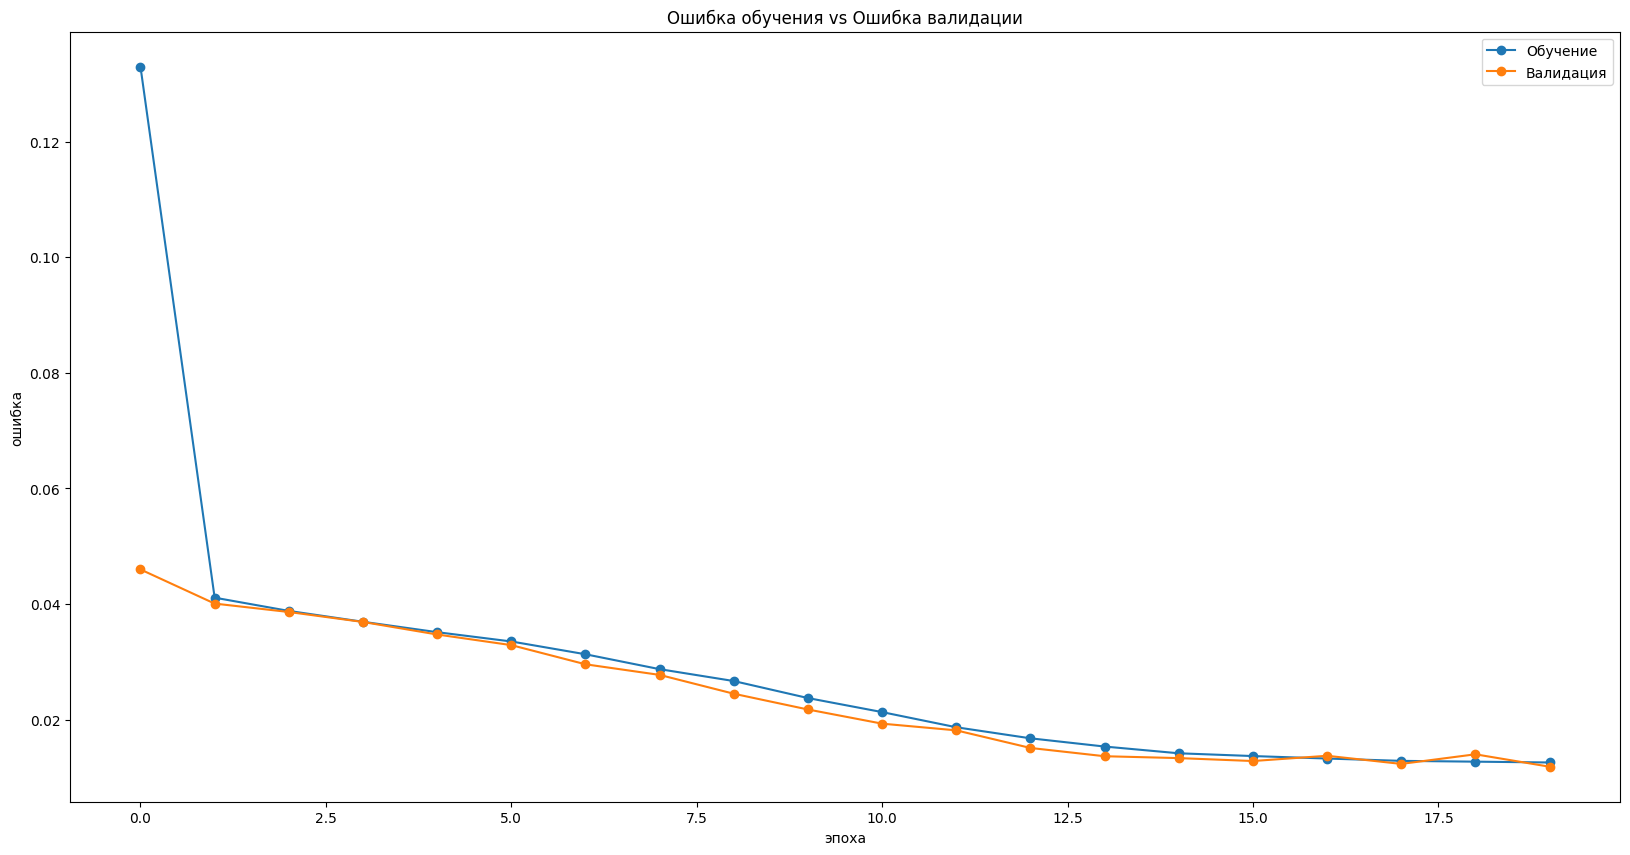

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

In [ ]:
pred = []
XX=np.linspace(-2,10,num=N)
for xx in XX:
  xx=torch.tensor(xx, dtype=torch.float)
  xx=xx.to(device)
  out=model(xx)
  out=out.to('cpu').detach().numpy()
  pred.append(out)

In [ ]:
pred=np.array(pred).flatten()

(0.0, 2.0)

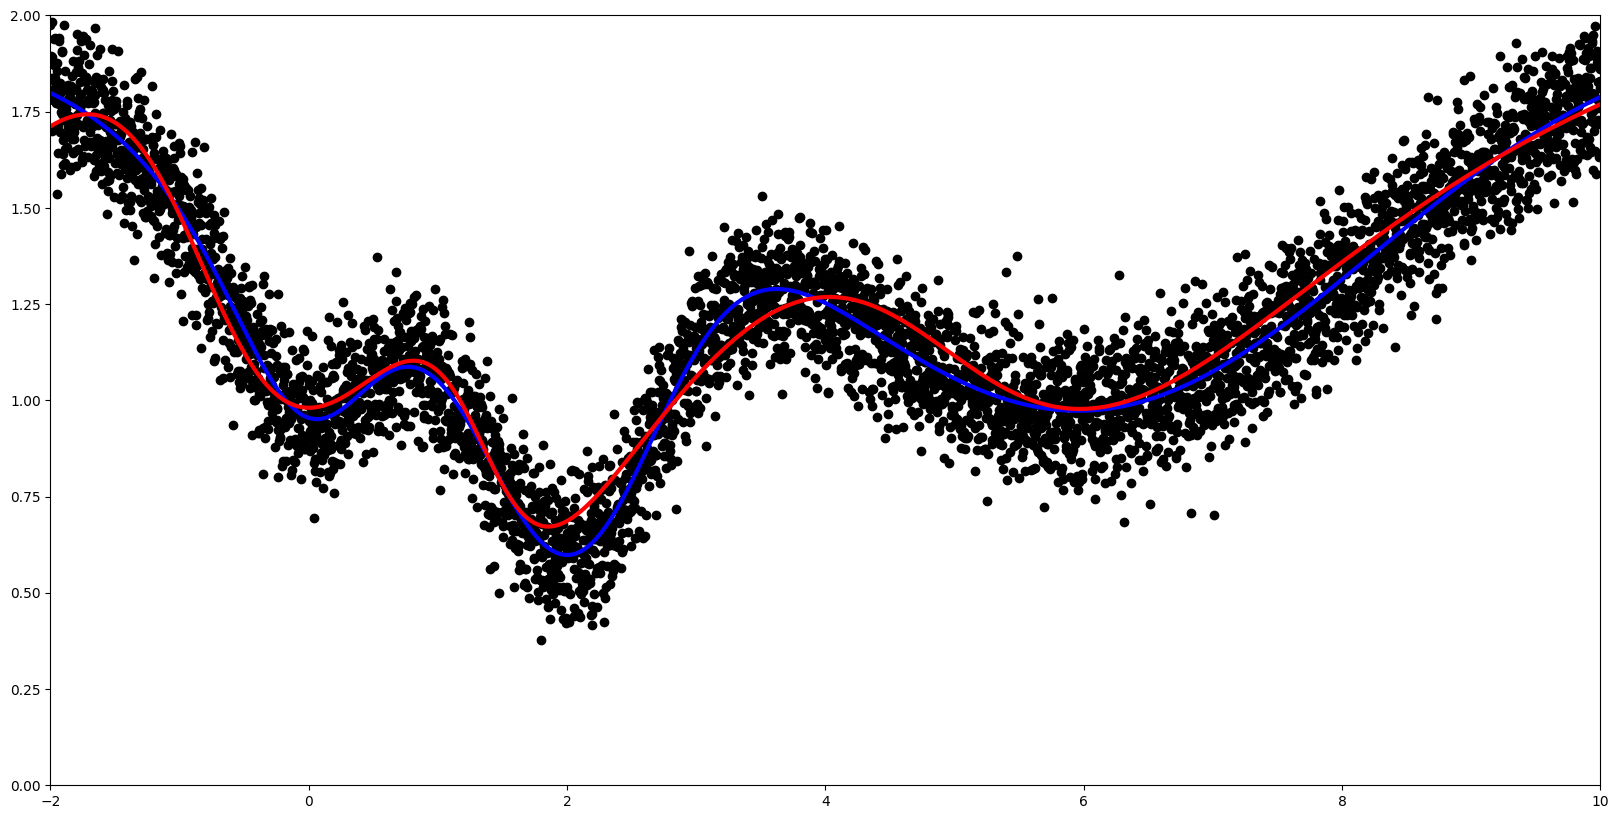

In [ ]:
fig = plt.figure()
plt.plot(X, y_true, color='blue',linewidth=3.0)
plt.scatter(X, y, color='black')
plt.plot(XX, pred, color='red',linewidth=3.0)
plt.xlim([-2.0,10.0])
plt.ylim([0.0,2.0])

Выведем веса модели. Посмотрим нет ли "мертвых" нейронов.

In [ ]:
for param in model.parameters():
  print(param.data)

tensor([[-1.2825],
        [ 0.6920],
        [ 0.2052],
        [-0.2131],
        [-1.1154],
        [ 1.9305],
        [ 0.1260],
        [ 0.2227],
        [-0.2786],
        [ 0.1065]])
tensor([-0.9576, -3.3764,  0.1091, -0.0999, -1.0158, -2.5987,  0.6384, -1.1981,
         0.1391,  1.0058])
tensor([[ 0.5316, -1.0523,  0.4640, -0.7894,  0.6001, -0.6563,  0.6144,  1.4317,
         -0.5973,  0.7831]])
tensor([0.3393])
